# Machine Learning starterkit


In [1]:
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import uproot

In [2]:
# avoid pandas warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## uproot

uproot is a Python package that provides tools for reading/writing ROOT files using Python and Numpy (does not depend on ROOT) and is primarly intended to stream data into machine learning libraries in Python.

We use uproot for reading and converting ROOT Trees into ***pandas*** **DataFrame**.

For more details: https://github.com/scikit-hep/uproot.

In [3]:
signal_tree = uproot.open('data/SignalTree.root')['SignalTable']
background_tree = uproot.open('data/LikeSignTree.root')['BackgroundTable']

data_tree = uproot.open('data/DataTree.root')['DataTable']

In [4]:
signal_tree.keys()

[b'HypCandPt',
 b'TPCnSigmaHe3',
 b'ct',
 b'InvMass',
 b'ArmenterosAlpha',
 b'V0CosPA',
 b'V0Chi2',
 b'PiProngPt',
 b'He3ProngPt',
 b'ProngsDCA',
 b'He3ProngPvDCA',
 b'PiProngPvDCA',
 b'He3ProngPvDCAXY',
 b'PiProngPvDCAXY',
 b'NpidClustersHe3',
 b'NpidClustersPion',
 b'TPCnSigmaPi',
 b'Lrec',
 b'centrality',
 b'V0radius',
 b'Rapidity',
 b'PseudoRapidityHe3',
 b'PseudoRapidityPion']

In [5]:
df_signal = signal_tree.pandas.df()
df_background = background_tree.pandas.df()
df_data = data_tree.pandas.df()

del signal_tree
del background_tree
del data_tree

## Pandas 

Pandas is a library that provides data structures and analysis tools for Pyhton. The two primary data structures of pandas are **Series** (1-dimensional) and **DataFrame** (2-dimensional) and we will work with them.

- **Series** are 1-dimensional ndarray with axis labels.
- **DataFrame** are 2-dimensional tabular data structure with labeled axes (rows and columns).

For more details: https://pandas.pydata.org/pandas-docs/stable/



### Series

In [6]:
quark_list = ['Up', 'Down', 'Charm', 'Strange', 'Top', 'Bottom']

quark_ser = pd.Series(quark_list)

In [7]:
quark_ser

0         Up
1       Down
2      Charm
3    Strange
4        Top
5     Bottom
dtype: object

In [8]:
quark_ser.index

RangeIndex(start=0, stop=6, step=1)

In [9]:
quark_ser.values

array(['Up', 'Down', 'Charm', 'Strange', 'Top', 'Bottom'], dtype=object)

We can also define our indexing.

In [10]:
# data and index must have same lenght (obviously)!
quark_indices = ['q1', 'q2', 'q3', 'q4', 'q5', 'q6']

# Series with custom indexing
quark_ser = pd.Series(data=quark_list, index=quark_indices)

In [11]:
# we can acces elements by element position
quark_ser[0]

'Up'

In [12]:
# or using  index label
quark_ser['q2']

'Down'

In [13]:
# we can do operations
ser1 = pd.Series([1,2,3,4,5])
ser2 = pd.Series([5,4,3,2,1])

ser_sum = ser1 + ser2
ser_product = ser1 * ser2

In [14]:
ser_sum.values

array([6, 6, 6, 6, 6])

In [15]:
ser_product.values

array([5, 8, 9, 8, 5])



### DataFrame

Can be thought of as a dict-like container for Series objects.

In [16]:
quark_df = pd.DataFrame(data=quark_list, columns=['names'])

quark_df

,names
0,Up
1,Down
2,Charm
3,Strange
4,Top
5,Bottom


In [17]:
symbols = ['u', 'd', 'c', 's', 't', 'b']
charge = [2/3, -1/3, 2/3, -1/3, 2/3, -1/3]
generation = [1, 1, 2, 2, 3, 3]

quark_df['symbol'] = symbols
quark_df['charge'] = charge
quark_df['generation'] = generation

quark_df

,names,symbol,charge,generation
0,Up,u,0.666667,1
1,Down,d,-0.333333,1
2,Charm,c,0.666667,2
3,Strange,s,-0.333333,2
4,Top,t,0.666667,3
5,Bottom,b,-0.333333,3


In [18]:
# accessing columns like dictionaries (return pandas Series)
quark_df['symbol']

0    u
1    d
2    c
3    s
4    t
5    b
Name: symbol, dtype: object

In [19]:
dictionary = {'integer': range(0,1000)}

df = pd.DataFrame(dictionary)

df.head()

,integer
0,0
1,1
2,2
3,3
4,4


In [20]:
df['pow2'] = [x*x for x in range(0,1000)]

df.head()

,integer,pow2
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16




One of the most interesting tool of DataFrame is the *query()* method (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html). With this method we can query the DataFrame getting elements which **satisfy a boolean expression**.

In [21]:
# example
df.query('integer>100 and pow2<14000')

,integer,pow2
101,101,10201
102,102,10404
103,103,10609
104,104,10816
105,105,11025
106,106,11236
107,107,11449
108,108,11664
109,109,11881
110,110,12100


## Let's get back to our data

In [22]:
df_signal.head()

,HypCandPt,TPCnSigmaHe3,ct,InvMass,ArmenterosAlpha,V0CosPA,V0Chi2,PiProngPt,He3ProngPt,ProngsDCA,...,PiProngPvDCAXY,NpidClustersHe3,NpidClustersPion,TPCnSigmaPi,Lrec,centrality,V0radius,Rapidity,PseudoRapidityHe3,PseudoRapidityPion
entry,,,,,,,,,,,,,,,,,,,,,
0,5.244245,0.145766,2.932166,2.992442,-0.855865,0.999995,0.00,0.349983,4.898814,0.00,...,0.760,51.0,123.0,0.500,5.452448,11.05,5.139171,-0.302478,-0.326804,-0.604579
1,6.692847,-1.099095,2.982722,2.992018,0.929519,0.999989,0.76,0.276486,6.422710,0.02,...,1.255,70.0,124.0,-0.625,7.681448,3.65,6.690947,0.499309,0.553692,0.263937
2,4.885914,-0.308452,2.271562,2.986345,-0.893218,0.999717,0.12,0.269636,4.632529,0.22,...,1.210,139.0,125.0,0.250,3.738053,12.05,3.706283,-0.104368,-0.110479,-0.313379
3,2.369037,-0.720452,2.741637,2.999815,0.899992,0.999238,10.24,0.185041,2.227235,0.68,...,0.975,79.0,110.0,1.250,2.777023,6.95,2.148513,0.475988,0.748612,0.326224
4,2.485672,-0.376143,3.762780,2.992071,0.865260,0.999988,0.00,0.204470,2.318309,0.00,...,1.765,128.0,111.0,-0.500,3.445189,6.95,3.133908,0.291510,0.449830,0.343804


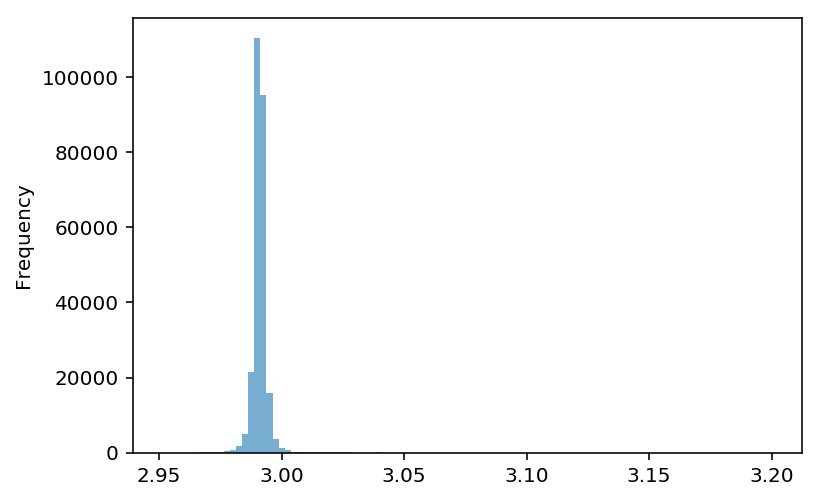

In [23]:
minv_sig = df_signal['InvMass'].plot.hist(bins=100, alpha=0.6)

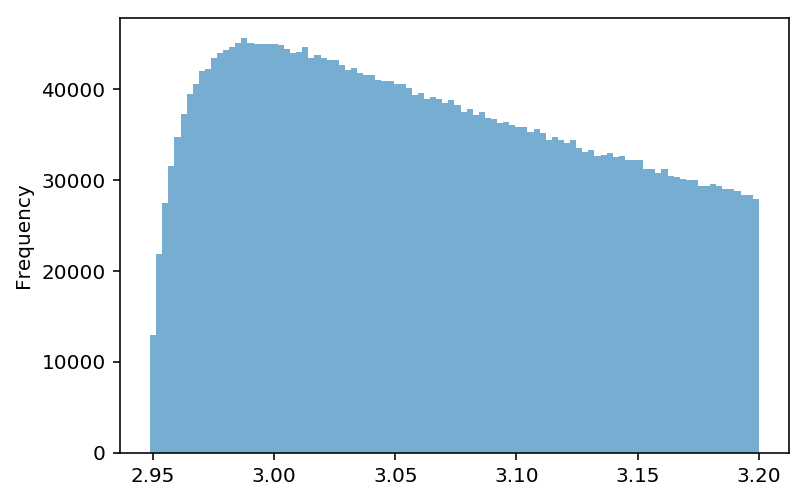

In [24]:
minv_bkg = df_background['InvMass'].plot.hist(bins=100, alpha=0.6)

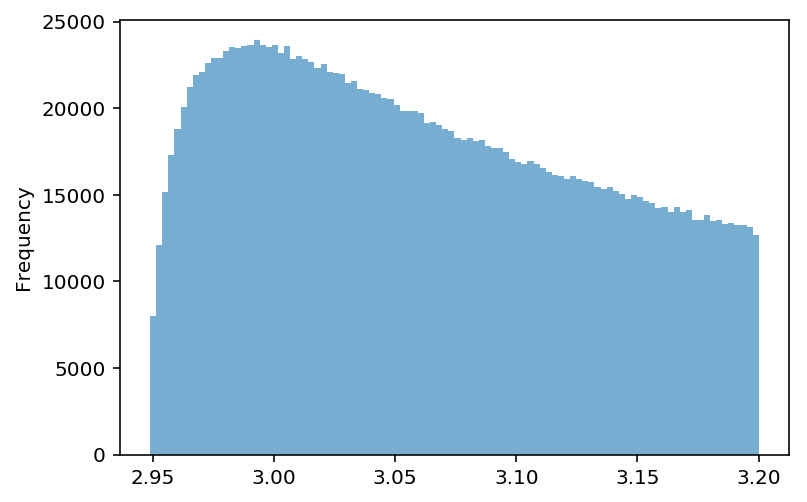

In [25]:
minv_data = df_data['InvMass'].plot.hist(bins=100, alpha=0.6)

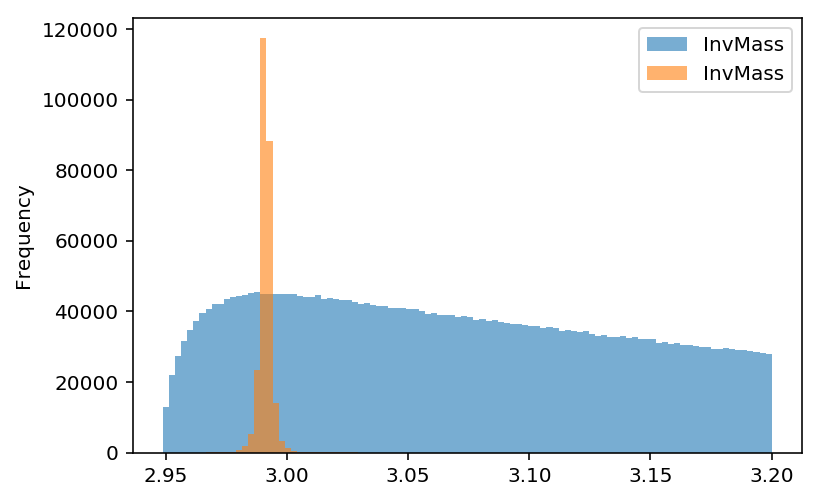

In [26]:
df = pd.concat([df_background['InvMass'], df_signal['InvMass']], axis=1)
minv_compared = df.plot.hist(bins=100, alpha=0.6)

- Now we label signal and background with the 'y' column **y=1** for signal and **y=0** for background. This will be the reference for the ML model. 

In [27]:
df_signal['y'] = 1
df_background['y'] = 0

df_ml = pd.concat([df_signal, df_background], axis=0)

df_ml.head()

,ArmenterosAlpha,He3ProngPt,He3ProngPvDCA,He3ProngPvDCAXY,HypCandPt,InvMass,Lrec,NpidClustersHe3,NpidClustersPion,PiProngPt,...,PseudoRapidityPion,Rapidity,TPCnSigmaHe3,TPCnSigmaPi,V0Chi2,V0CosPA,V0radius,centrality,ct,y
entry,,,,,,,,,,,,,,,,,,,,,
0,-0.855865,4.898814,0.12,0.035,5.244245,2.992442,5.452448,51.0,123.0,0.349983,...,-0.604579,-0.302478,0.145766,0.500,0.00,0.999995,5.139171,11.05,2.932166,1
1,0.929519,6.422710,0.14,0.060,6.692847,2.992018,7.681448,70.0,124.0,0.276486,...,0.263937,0.499309,-1.099095,-0.625,0.76,0.999989,6.690947,3.65,2.982722,1
2,-0.893218,4.632529,0.17,0.150,4.885914,2.986345,3.738053,139.0,125.0,0.269636,...,-0.313379,-0.104368,-0.308452,0.250,0.12,0.999717,3.706283,12.05,2.271562,1
3,0.899992,2.227235,0.01,0.005,2.369037,2.999815,2.777023,79.0,110.0,0.185041,...,0.326224,0.475988,-0.720452,1.250,10.24,0.999238,2.148513,6.95,2.741637,1
4,0.865260,2.318309,0.16,0.160,2.485672,2.992071,3.445189,128.0,111.0,0.204470,...,0.343804,0.291510,-0.376143,-0.500,0.00,0.999988,3.133908,6.95,3.762780,1


## Exploring training variables (features)

In [28]:
import os
import sys
sys.path.insert(0, '../')

import analysis_utils as au

In [29]:
columns = ['HypCandPt',
           'TPCnSigmaHe3',
           'V0CosPA',
           'ProngsDCA',
           'He3ProngPvDCA',
           'PiProngPvDCA',
           'He3ProngPvDCAXY',
           'PiProngPvDCAXY',
           'NpidClustersHe3']

In [30]:
# example for single variable as before + exercise

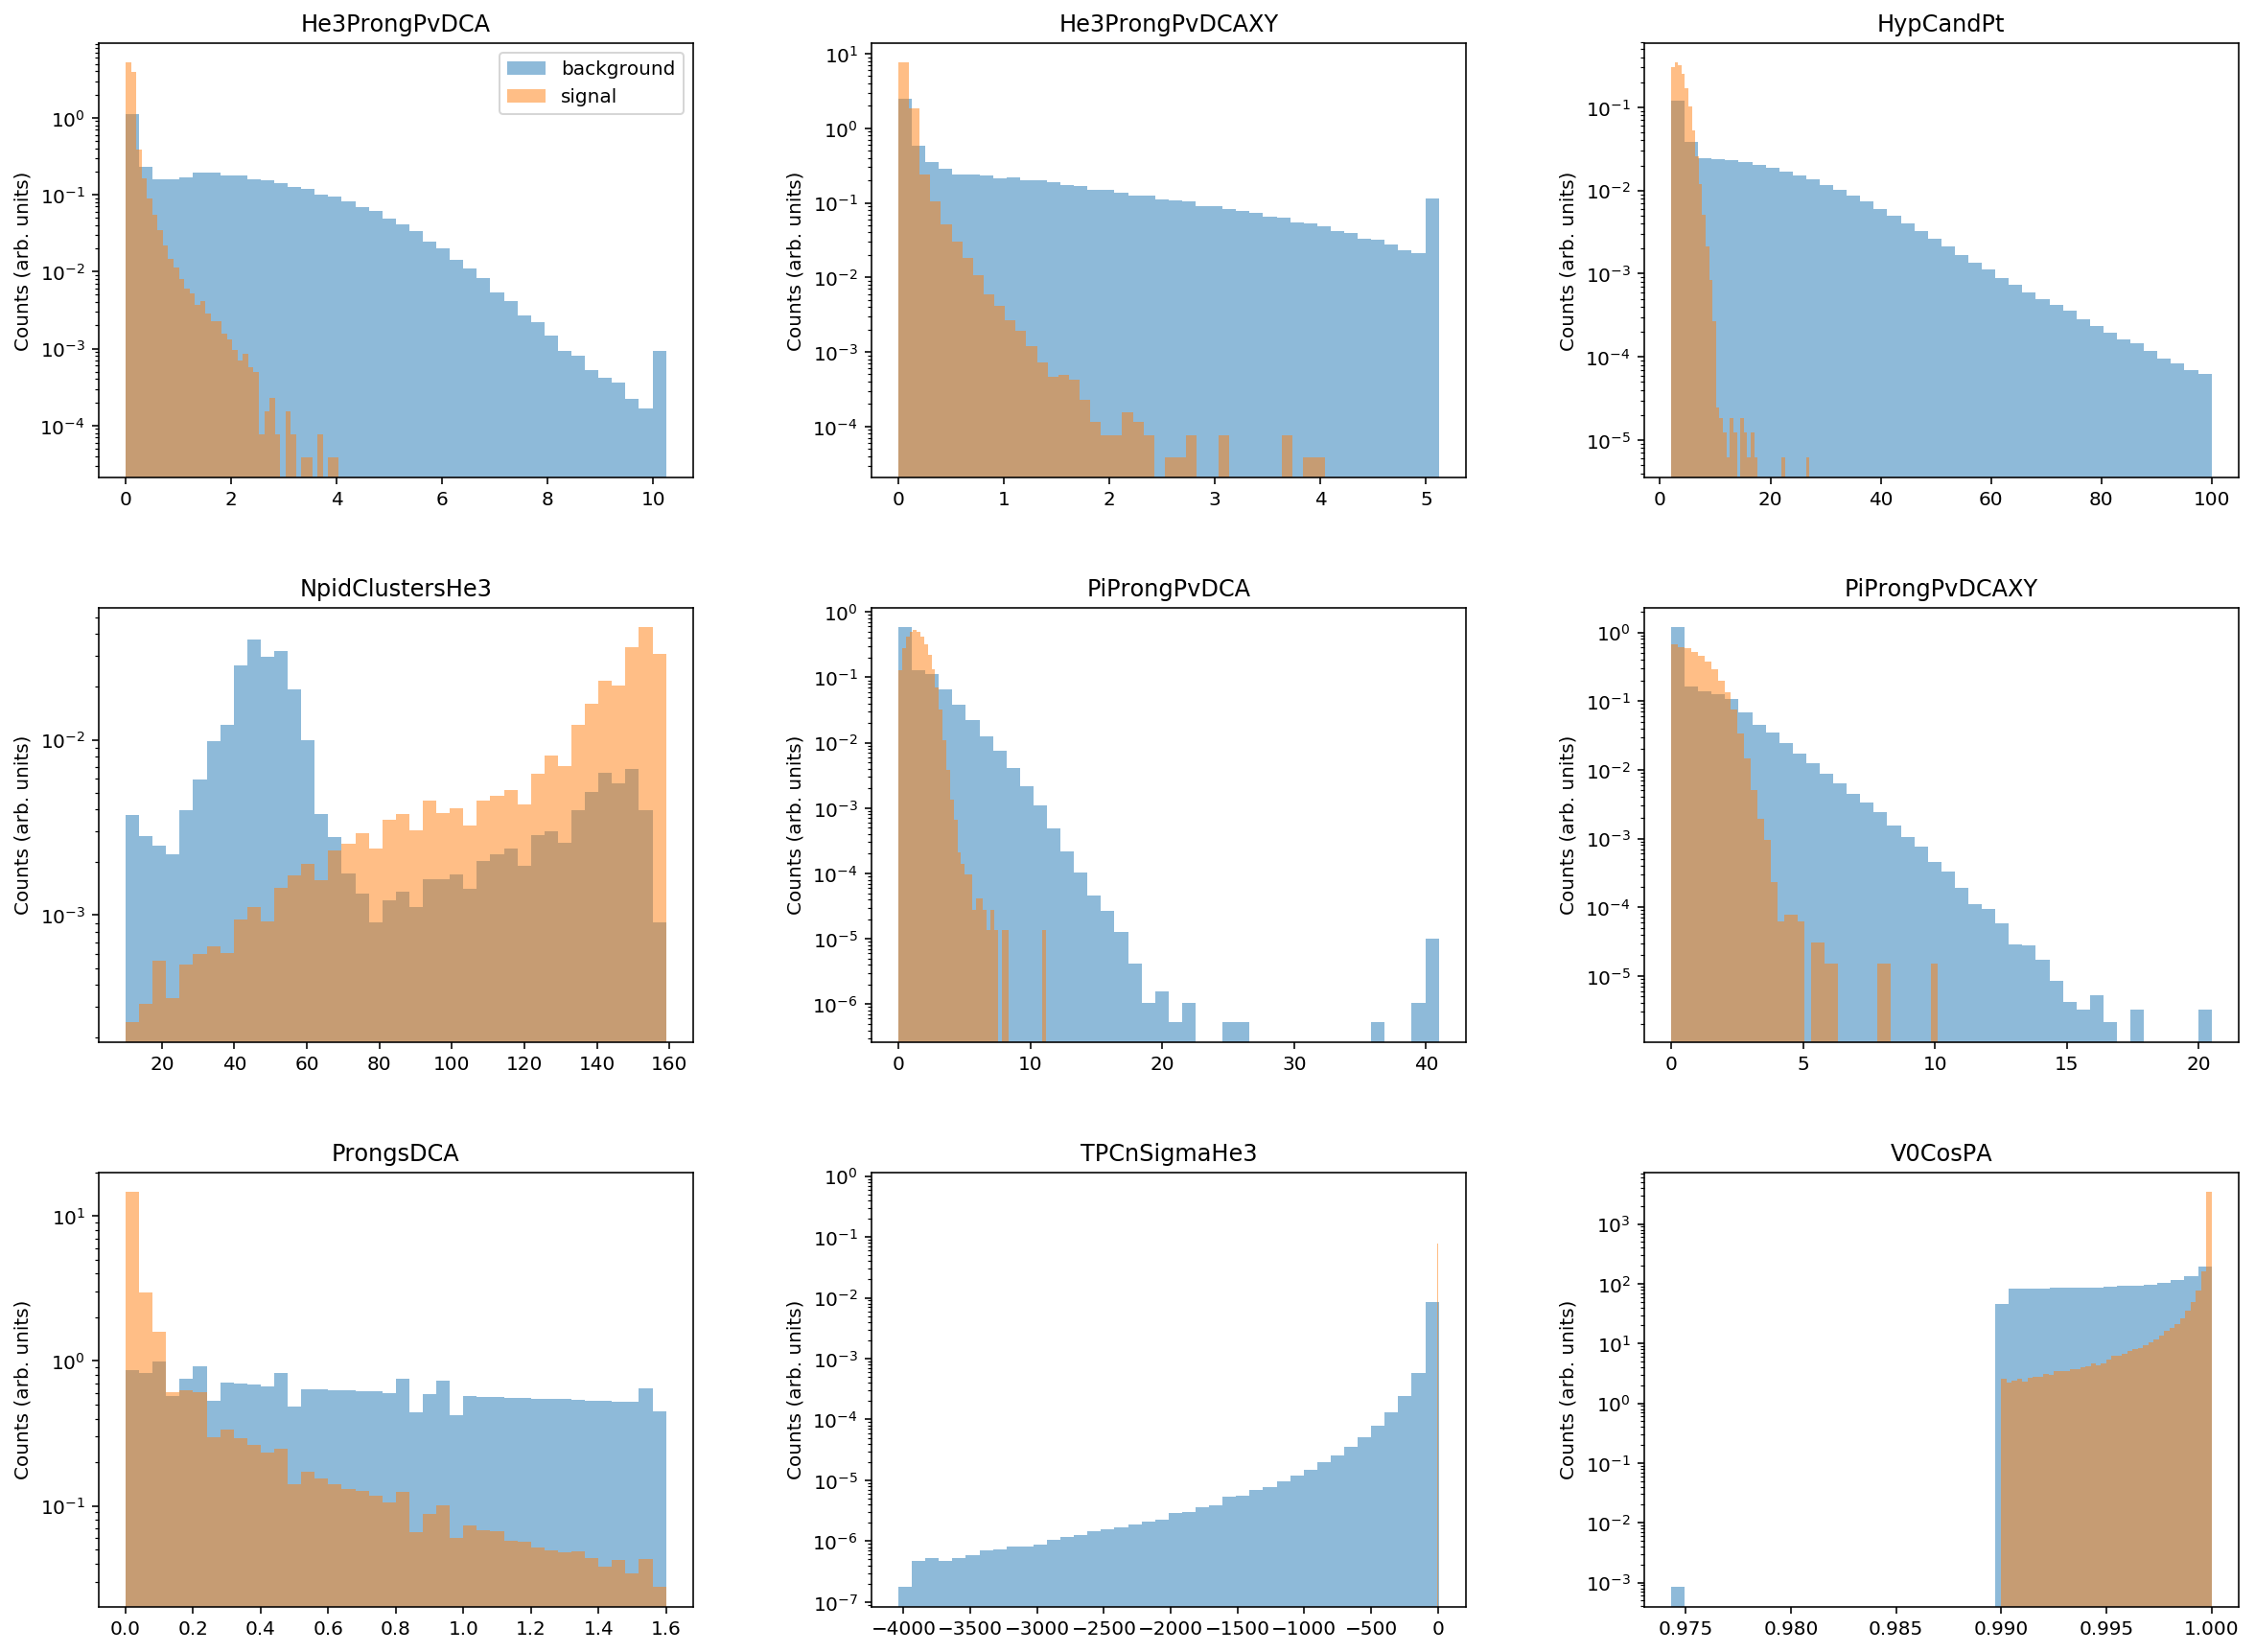

In [31]:
au.plot_distr(df_ml, columns, bins=40)

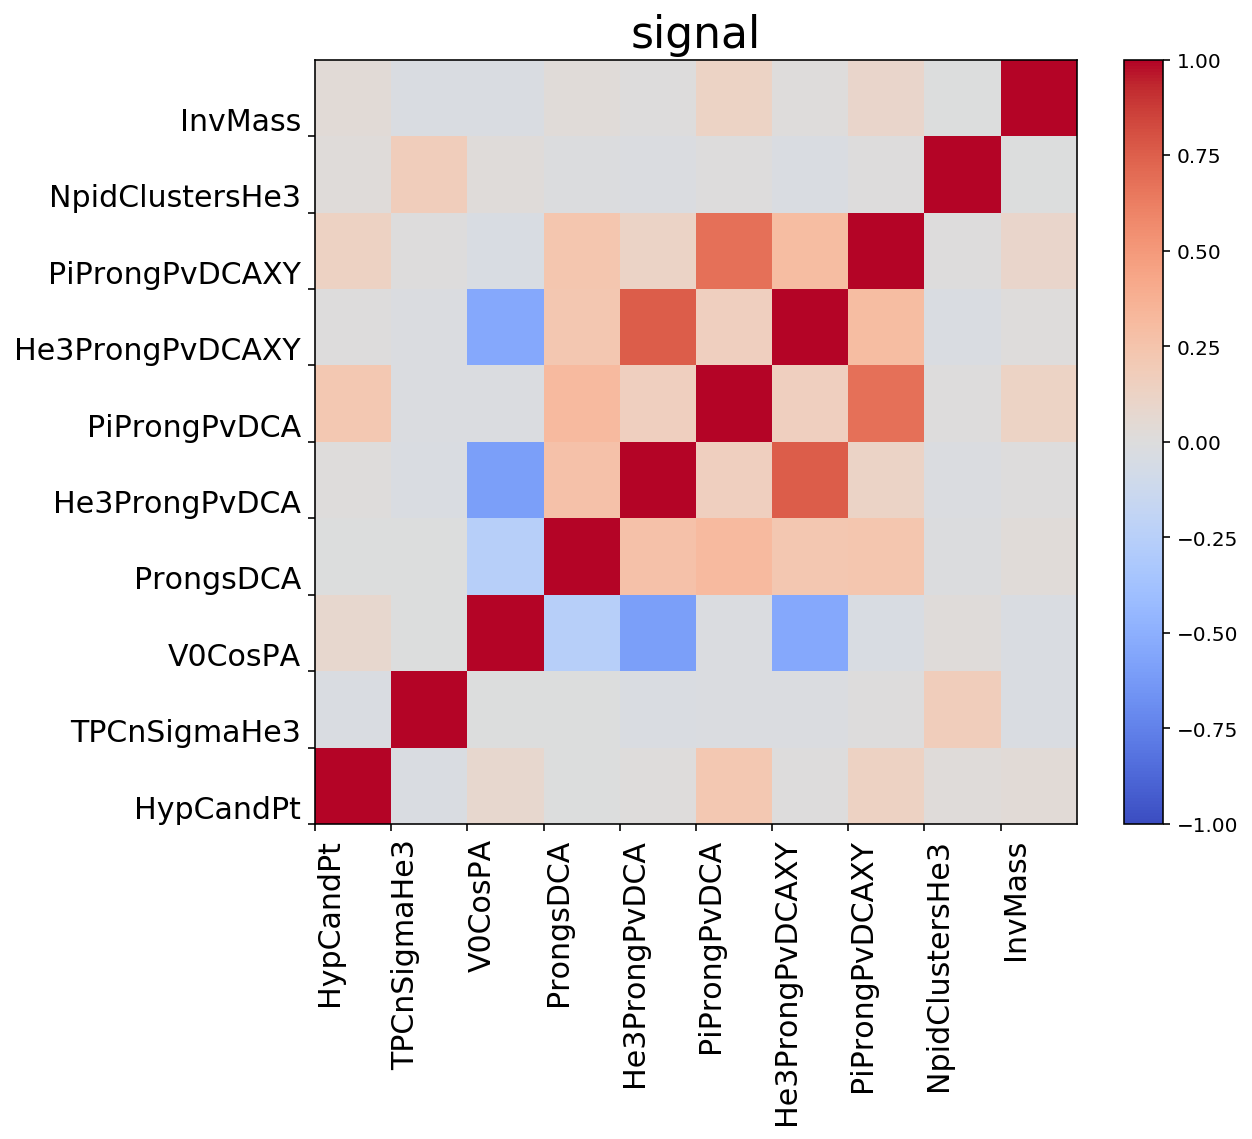

In [32]:
au.plot_corr(df_ml, columns, 'signal')

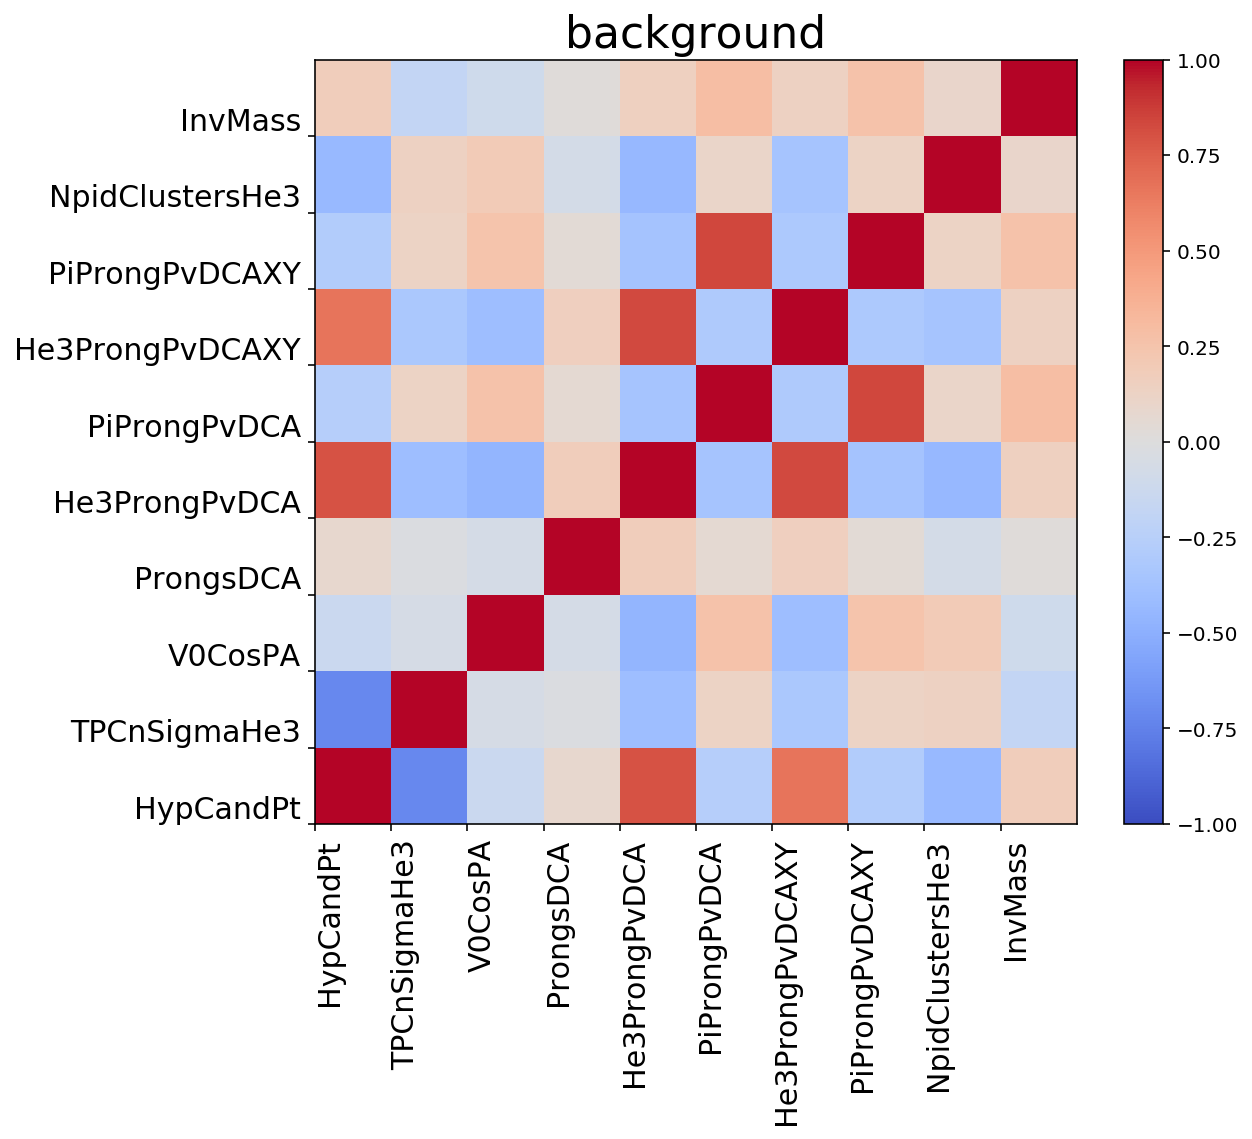

In [33]:
au.plot_corr(df_ml, columns, 'background')

## Train-Test split

In [34]:
seed = 42

train_set, test_set, y_train, y_test = train_test_split(df_ml[columns], df_ml['y'], test_size=0.5, random_state=42)

In [35]:
print('train set lenght: {}'.format(len(train_set)))
print('test set lenght:  {}'.format(len(test_set)))

train set lenght: 1967732
test set lenght:  1967733


## Example with simple (and weak) predictor

In [36]:
from sklearn.naive_bayes import GaussianNB

In [37]:
#Create a Gaussian Classifier
nb_model = GaussianNB()

nb_model.fit(train_set[columns], y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [38]:
y_nb = nb_model.predict(test_set[columns])

nb_score = roc_auc_score(y_test, y_nb)
print('ROC_AUC_score: {}'.format(nb_score))

ROC_AUC_score: 0.8934340753183261


In [39]:
y_pred = nb_model.predict(df_data[columns])

In [40]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

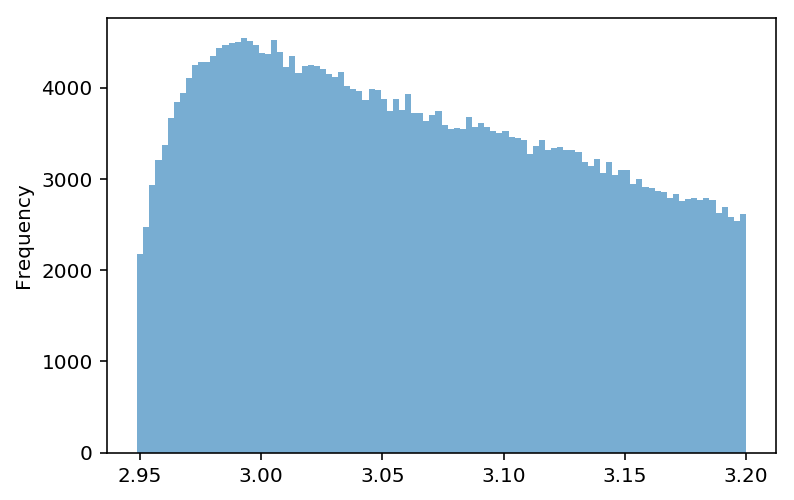

In [41]:
df_data['y_nb'] = y_pred

df_data.query('y_nb>0.5')['InvMass'].plot.hist(bins=100, alpha=0.6)

## *XGBoost*

In [42]:
xgb_params = {'objective': 'binary:logistic', 
              'tree_method': 'hist',
              'random_state': 42,
              'silent': 1}

In [51]:
#un giro iperparametri scarsi, un altro iperparametri buoni, un altro iperparametri mass shaping -load modello-
#confronto ottimo non ottimo -non sovrascrivere modelli- 

hyperparams = {'max_depth': 3,
               'learning_rate': 0.01,
               'n_estimators': 50,
               'subsample': 0.7,
               'colsample_bytree': 0.6}

# hyperparams = {'max_depth': 13,
#                'learning_rate': 0.0982,
#                'n_estimators': 181,
#                'gamma': 0.4467,
#                'min_child_weight': 5.75,
#                'subsample': 0.74,
#                'colsample_bytree': 0.57}

params = {**xgb_params, **hyperparams}

In [52]:
simple_model = xgb.XGBClassifier(**params)

simple_model.fit(train_set[columns], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7, tree_method='hist', verbosity=1)

In [53]:
y_test_pred = simple_model.predict_proba(test_set[columns]).T[1]

# y_pred = model_def.predict(df_data[columns])
# df_data['y'] = y_pred

model_score = roc_auc_score(y_test, y_test_pred)
print('ROC_AUC_score: {}'.format(model_score))

ROC_AUC_score: 0.9910837080867817


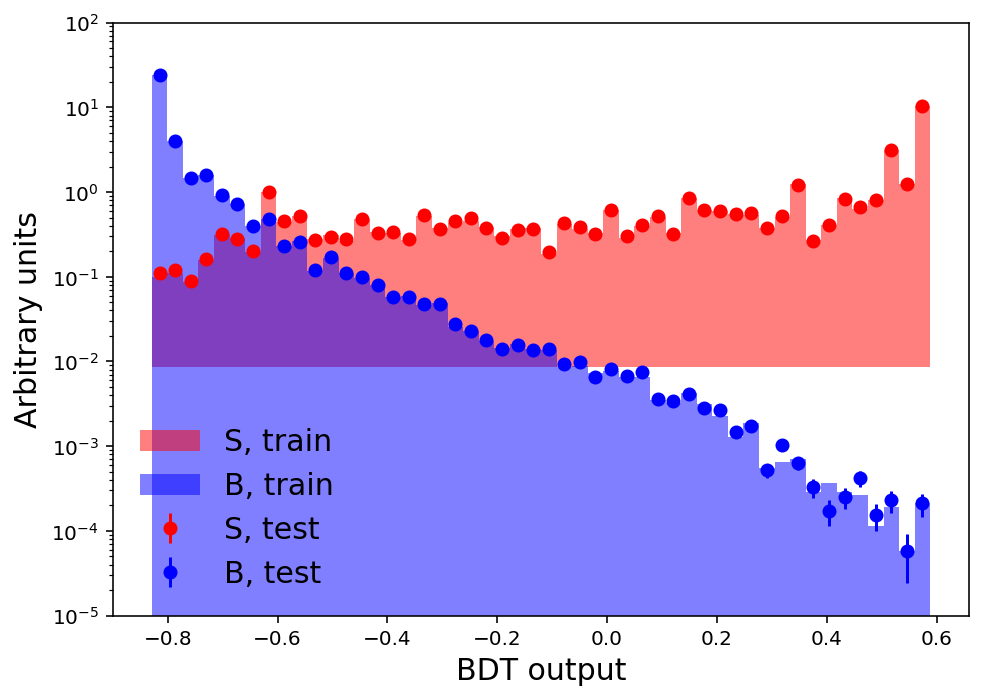

In [54]:
au.plot_output_train_test(simple_model, train_set, y_train, test_set, y_test, columns=columns, figsize=(7,5), log=True)

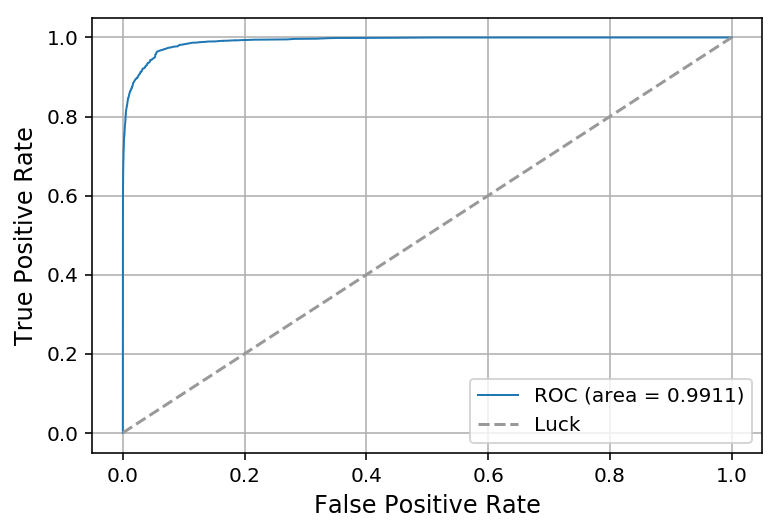

In [55]:
au.plot_roc(y_test, y_test_pred)

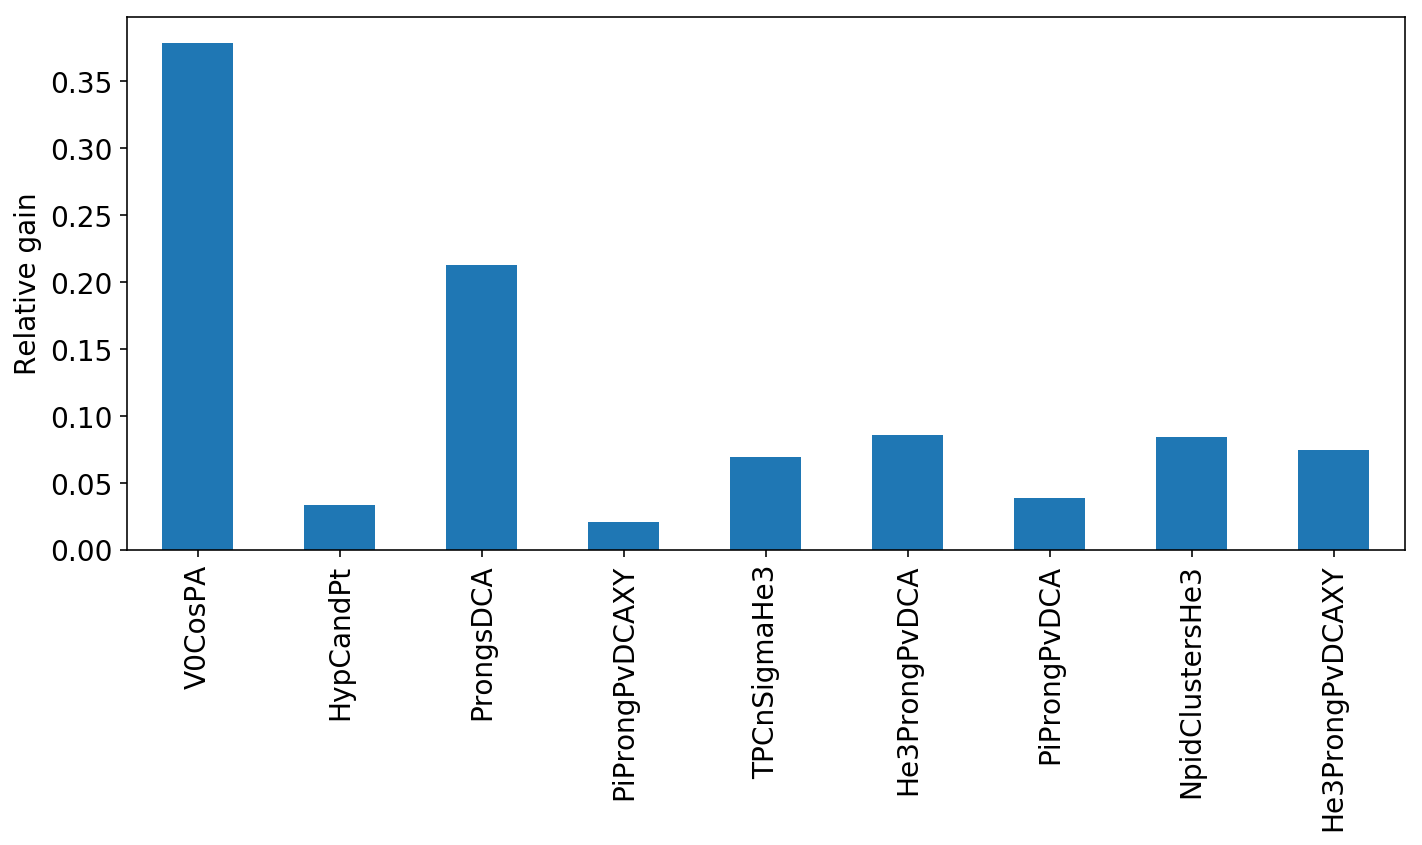

In [56]:
au.plot_feature_imp(simple_model, imp_list=['gain'])

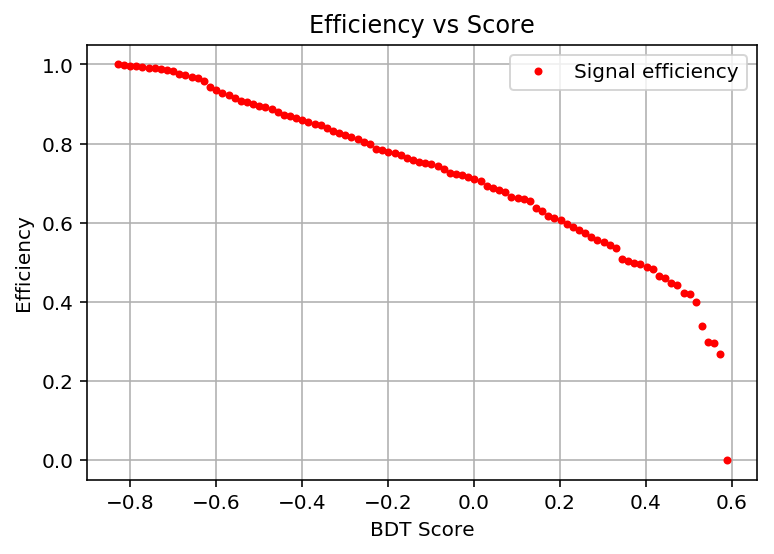

In [57]:
# BDT efficiency
y_pred = simple_model.predict(test_set[columns], output_margin=True)

test_set.eval('score = @y_pred', inplace=True)
test_set.eval('y = @y_test', inplace=True)

min_score = test_set['score'].min()
max_score = test_set['score'].max()

threshold = np.linspace(min_score, max_score, 100)

efficiency = []

n_sig = sum(test_set['y'])

for t in threshold:
    df_selected = test_set.query('score>@t')['y']
    sig_selected = np.sum(df_selected)
    efficiency.append(sig_selected / n_sig)

au.plot_bdt_eff(threshold, efficiency)

## Model application on data

In [50]:
y_pred = model_def.predict(df_data[columns], output_margin=True)
df_data.eval('score = @y_pred', inplace=True)

NameError: name 'model_def' is not defined

In [ ]:
plot = df_data.query('score>3.24')['InvMass'].plot.hist(bins=100, alpha=0.6)

## Mass Shaping

If the model overfit the data

In [ ]:
#confronto mass shaping ottimo - overfit

In [ ]:
y_pred_ms = model_def.predict(df_background[columns], output_margin=True)
df_background.eval('score = @y_pred_ms', inplace=True)

In [ ]:
plot = df_background.query('score>2')['InvMass'].plot.hist(bins=80, alpha=0.6)

In [ ]:
# esercizio tagli lineari

In [ ]:
# TO DO accenno valore di taglio
# TO DO scan taglio - esercizio per un taglio 